In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import glob
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import keras
print(keras.backend.image_data_format())
from keras.models import Model


Using TensorFlow backend.


channels_last


In [2]:
current_path = os.getcwd()
output_path = f"{current_path}/output"
csv_path = f"{output_path}/csv"
output_train_path = f"{output_path}/train"

In [3]:
train_csv_list = glob.glob(f"{csv_path}/*_train.csv")


In [4]:
pred_csv_list=train_csv_list.pop(1)
pred_csv_list = [pred_csv_list]
print([pred_csv_list])

[['/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190123_train.csv']]


In [5]:
def read_csv_to_df(train_csv_list):
    columns = ["lu_x","lu_y","ru_x","ru_y","ld_x","ld_y","rd_x","rd_y"]
    return_dict = {}
    dir_list=[]
    df_concat = pd.Series([0,0,0,0,0,0,0,0],index = columns)
    for train_csv in train_csv_list:
        dir_path = train_csv.split('/')[-1].rstrip("_train.csv")
        print(train_csv)
        read_df = pd.read_csv(train_csv,index_col=0)
        df_concat = pd.concat([df_concat, read_df.T],axis=1)
        return_dict.update({dir_path:df_concat.T[1:]})
        dir_list.append(dir_path)
        df_concat = pd.Series([0,0,0,0,0,0,0,0],index = columns)
    return return_dict,dir_list

In [6]:
train_csv_dict, train_dir_list = read_csv_to_df(train_csv_list)

#test_csv_dict, test_dir_list  = read_csv_to_df(test_csv_list)
pred_csv_dict, pred_dir_list  = read_csv_to_df(pred_csv_list)

label = train_csv_dict["001"].columns

/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/002_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/004_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/001_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/003_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190125_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190124_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190123_train.csv


In [60]:
def data_pack(csv_dict, dir_list,train_path):
    img_shape = 200.
    x_data =[]
    y_data=[]
    data_list = []

    for name in dir_list:
        train_dir_path = f"{train_path}/{name}"

        index_list = csv_dict[name].index.values
        
        #tmp_dir = [f"{train_dir_path}/img_name" for img_name in index_list]
        data_list.extend(index_list)


        x_list = [img_to_array(load_img(f"{train_dir_path}/train_{val}.jpg"))/255. for val in index_list]
        
        y_list = [csv_dict[name].loc[val].values/img_shape for val in index_list]

        print(name)
        x_list = np.array(x_list)
        print(x_list.shape)
        y_list = np.array(y_list)
        print(y_list.shape)
        
        x_data.append(x_list)
        y_data.append(y_list)
        
        #return x_data, y_data
    return np.vstack(x_data), np.vstack(y_data),data_list

In [61]:
x_train,y_train,train_data_list=data_pack(train_csv_dict, train_dir_list, output_train_path)
print("==============-")
pred_x_test,pred_y_test,pred_data_list=data_pack(pred_csv_dict, pred_dir_list,output_train_path)

002
(71, 200, 200, 3)
(71, 8)
004
(348, 200, 200, 3)
(348, 8)
001
(302, 200, 200, 3)
(302, 8)
003
(157, 200, 200, 3)
(157, 8)
20190125
(34, 200, 200, 3)
(34, 8)
20190124
(27, 200, 200, 3)
(27, 8)
==============-
20190123
(128, 200, 200, 3)
(128, 8)


In [62]:
print(x_train.shape)

(939, 200, 200, 3)


In [9]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.utils import plot_model

In [10]:
model = Sequential()

print(x_train.shape[1:])
model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3) ,padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1, 1) ,padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
#model.add(Activation('softmax'))

(200, 200, 3)



In [19]:
from keras.optimizers import Adam, Nadam
nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_absolute_error',
                  optimizer=nadam,
                  metrics=['squared_hinge'])

In [20]:
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.1)

Train on 845 samples, validate on 94 samples
Epoch 1/50
845/845 [==============================] - 118s 140ms/step - loss: 0.7840 - squared_hinge: 1.2372 - val_loss: 0.5062 - val_squared_hinge: 0.8952
Epoch 2/50
845/845 [==============================] - 117s 139ms/step - loss: 0.6615 - squared_hinge: 1.0917 - val_loss: 0.4443 - val_squared_hinge: 0.7106
Epoch 3/50
845/845 [==============================] - 117s 139ms/step - loss: 0.5708 - squared_hinge: 0.8796 - val_loss: 0.5480 - val_squared_hinge: 0.6147
Epoch 4/50
845/845 [==============================] - 117s 139ms/step - loss: 0.4963 - squared_hinge: 0.7310 - val_loss: 0.4086 - val_squared_hinge: 0.5752
Epoch 5/50
845/845 [==============================] - 117s 139ms/step - loss: 0.4288 - squared_hinge: 0.6673 - val_loss: 0.7856 - val_squared_hinge: 1.1688
Epoch 6/50
845/845 [==============================] - 118s 139ms/step - loss: 0.4034 - squared_hinge: 0.7060 - val_loss: 0.5661 - val_squared_hinge: 0.7983
Epoch 7/50
845/845 

In [26]:
model.save(f"{output_path}/test.h5")
#plot_model(model, to_file=f"{output_path}/test.png")

In [27]:
from keras.models import load_model
l_mode=load_model(f"{output_path}/test.h5")

In [28]:
score = l_mode.evaluate(pred_x_test, pred_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23299871012568474
Test accuracy: 0.4259449541568756


In [29]:
l_mode.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 200, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 32)     

In [30]:
pred_his = l_mode.predict(pred_x_test)
print(pred_his)

[[0.6107299  0.54899204 0.5412401  ... 0.60496795 0.63531095 0.6409596 ]
 [0.68729967 0.6007798  0.69509774 ... 0.65946263 0.75801414 0.67565453]
 [0.53608096 0.7032614  0.6747147  ... 0.79453146 0.7066305  0.7711067 ]
 ...
 [0.9820153  0.6005558  0.8972172  ... 0.65169567 0.9483639  0.6383896 ]
 [0.44451421 0.6873096  0.59454715 ... 0.7771026  0.636935   0.7628404 ]
 [0.6484609  0.7008399  0.807749   ... 0.7859901  0.83569354 0.7450149 ]]


In [41]:
pred_his = l_mode.predict(pred_x_test[0:1])
print(pred_his)
print(pred_y_test[0:1])

[[0.61072975 0.54899204 0.54124004 0.43211472 0.6588821  0.60496795
  0.635311   0.6409595 ]]
[[0.26805623 0.64382872 0.47018905 0.70579345 0.24769753 0.74861461
  0.44740669 0.81360202]]


In [31]:
print(pred_x_test.shape)

(128, 200, 200, 3)


In [32]:
def check_img(image, y_label,name=None):
    im = image

    cv2.drawMarker(im,(int(y_label[0]),int(y_label[1])),(255,0,0), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[2]),int(y_label[3])),(0,255,0), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[4]),int(y_label[5])),(0,0,255), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[6]),int(y_label[7])),(0,0,0), markerType=cv2.MARKER_STAR)
    
    if name is not None:
        image_path =f"{current_path}/output/model/{name}.jpg"
        cv2.imwrite(image_path,im)
        return im
    else:
        return im
    del im

In [20]:
#print((pred_x_test[0]*255).astype(np.int16))

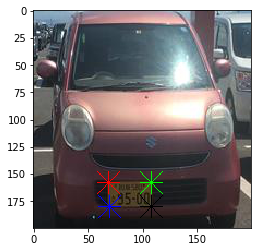

In [65]:
image=check_img((x_train[100]*255).astype(np.int16),y_train[100]*200)
plt.imshow(image)
test_img_path =f"{current_path}/output/model/test_img.jpg"
plt.savefig(test_img_path)

In [64]:
print(pred_y_test[0])

[0.26805623 0.64382872 0.47018905 0.70579345 0.24769753 0.74861461
 0.44740669 0.81360202]


In [35]:
for i,name in enumerate(pred_data_list):
    x_img = (pred_x_test[i]*255).astype(np.int16)
    pred_val = (pred_his[i]*200).astype(np.int16)
    check_img(x_img,pred_val,name)

In [36]:
from keras.preprocessing import image
params = {
    'rotation_range': 20,
    'width_shift_range': 0.1
}
datagen = image.ImageDataGenerator(**params)
gen = datagen.flow(x, batch_size=16)
print(len(x_train))
model.fit_generator(gen, steps_per_epoch=len(x_train) / 32, epochs=16)

TypeError: __init__() got an unexpected keyword argument 'interpolation_order'

README.md	 draw_marker.ipynb  resize.py	    test4.jpg
Untitled.ipynb	 keras_yolo3	    resized_df.csv  test5.jpg
Untitled1.ipynb  main.py	    ssd.ipynb	    test6.jpg
Untitled4.ipynb  model		    ssd_predict.py  test7.jpg
__pycache__	 my_yolo.py	    test.jpg	    test8.jpg
car_image	 output		    test0.jpg	    test9.jpg
cnn_model.ipynb  output.zip	    test1.jpg	    train_load.ipynb
custom_gen.py	 preprocess.py	    test2.jpg	    utils.py
data		 resize.ipynb	    test3.jpg
